In [1]:
from coral_imports import *
from coral_plotting import *
from coral_run_project import *
import matplotlib.ticker as tck

# Read in Pipeline and Libraries

In [2]:
base = os.path.join(os.getcwd(), "analysis", "configs", "base.yaml")
base_float = os.path.join(os.getcwd(), "analysis", "configs", "base_float.yaml")
library = os.path.join(os.getcwd(), "analysis", "library")
weather_fp = os.path.join(os.getcwd(), "analysis", "library", "weather", "vineyard_wind_repr_with_whales.csv")

weather = pd.read_csv(weather_fp, parse_dates=["datetime"])\
            .set_index("datetime")

# Create DFs based on CORAL runs

In [3]:
# set up yaml reading
def tuple_constructor(loader, node):
    # Load the sequence of values from the YAML node
    values = loader.construct_sequence(node)
    # Return a tuple constructed from the sequence
    return tuple(values)

# Register the constructor with PyYAML
yaml.SafeLoader.add_constructor('tag:yaml.org,2002:python/tuple', 
tuple_constructor)

In [4]:
scenarios = ['natl_gaps_4us']
# print(scenarios)

dfs = []
managers = []
all_alloc = []
all_future = []
cols = ['best_path_forward_south_ne', 'high_deployment_south_ne', 'low_deployment_south_ne', 'best_path_forward_north_ne', 'high_deployment_north_ne', 'low_deployment_north_ne']

yrs = np.arange(2023,2043,1)
installed_cap = pd.DataFrame(columns=cols, data = np.zeros((len(yrs), len(cols))), index = yrs)

for s in scenarios:
    with open('analysis/scenarios/%s.yaml' % s) as f:
        scenario = yaml.load(f.read(), Loader=yaml.SafeLoader)
    # print(scenario)
    p = os.path.join(os.getcwd(), "analysis", "pipelines", "%s.csv" % scenario['pipeline'])
    pipeline = Pipeline(p, base, base_float, enforce_feeders=True)

    description = scenario['description']
    allocations = scenario['allocations']
    future_resources = scenario['future_resources']

    manager, df = run_manager(pipeline, allocations, library, future_resources=future_resources)
    managers.append(manager)
    dfs.append(df)
    all_alloc.append(allocations)
    all_future.append(future_resources)

    # for region in ['south_ne', 'north_ne']:
    #     df_port = df.drop(columns=['index'])
    #     if region == 'south_ne':
    #         ports = ['new_bedford','new_london']
    #     else:
    #         ports = ['salem','searsport']
        
    #     df_region = df_port[df_port['port'].isin(ports)].reset_index(drop=True).reset_index()
    #     # display(df_region)
    #     df_region['finished'] = df_region['Date Finished'].dt.year
    #     df_finished = df_region.groupby(['finished']).capacity.sum().reset_index()
    #     # display(df_finished)
    #     mapping = dict(df_finished[['finished','capacity']].values)
    #     installed_cap['%s_%s' % (s,region)] = installed_cap.index.map(mapping)
# display(installed_cap)
# installed_cap.to_csv('analysis/results/installed_cap_%s.csv' % region)


ORBIT library intialized at 'c:\Users\sbredenk\Repos\ORBIT_natl_gaps\library'
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation:
TurbineInstallation

# Plot Vessel Utilization

In [5]:
yrs = np.arange(2023,2061)
df_util = pd.DataFrame(columns = ['wtiv', 'us_wtiv', 'ffiv', 'ahts'], index=yrs)
df_util = df_util.fillna(0)
# display(df_util)
df = dfs[0]

for _,project in df.iterrows():
    # FOUNDATIONS
    if project['substructure'] in ('monopile','jacket'):
        if project['Date FoundationFinished'].year == project['Date Started'].year:
            util = (project['Date FoundationFinished'].date() - project['Date Started'].date()).days * 24
            df_util.loc[project['Date FoundationFinished'].year,'ffiv'] += util
        else:
            total = project['Date FoundationFinished'].date() - project['Date Started'].date()
            for year in np.arange(project['Date Started'].year,project['Date FoundationFinished'].year + 1):
                if year == project['Date Started'].year:
                    util = (dt.date(year + 1, 1, 1) - project["Date Started"].date()).days * 24
                elif year == project['Date FoundationFinished'].year:
                    util = (project['Date FoundationFinished'].date() - dt.date(year,1,1)).days * 24
                else:
                    util = (dt.date(year + 1, 1, 1) - dt.date(year, 1, 1)).days * 24
                df_util.loc[year,'ffiv'] += util

    # TURBINES
    if project['substructure'] in ('monopile','jacket'):
        if project['Date Finished'].year == project['Date FoundationFinished'].year:
            util = (project['Date Finished'].date() - project['Date FoundationFinished'].date()).days * 24
            if project['us_wtiv']:
                df_util.loc[project['Date Finished'].year,'us_wtiv'] += util
            else:
                df_util.loc[project['Date Finished'].year,'wtiv'] += util
        else:
            total = project['Date Finished'].date() - project['Date FoundationFinished'].date()
            for year in np.arange(project['Date FoundationFinished'].year,project['Date Finished'].year + 1):
                if year == project['Date FoundationFinished'].year:
                    util = (dt.date(year + 1, 1, 1) - project["Date FoundationFinished"].date()).days * 24
                elif year == project['Date Finished'].year:
                    util = (project['Date Finished'].date() - dt.date(year,1,1)).days * 24
                else:
                    util = (dt.date(year + 1, 1, 1) - dt.date(year, 1, 1)).days * 24

                if project['us_wtiv']:
                    df_util.loc[year,'us_wtiv'] += util
                else:
                    df_util.loc[year,'wtiv'] += util
    else:
        if project['Date Finished'].year == project['Date Started'].year:
            util = (project['Date Finished'].date() - project['Date Started'].date()).days * 24
            df_util.loc[project['Date Finished'].year,'ffiv'] += util
        else:
            total = project['Date Finished'].date() - project['Date Started'].date()
            for year in np.arange(project['Date Started'].year,project['Date Finished'].year + 1):
                if year == project['Date Started'].year:
                    util = (dt.date(year + 1, 1, 1) - project["Date Started"].date()).days * 24
                elif year == project['Date Finished'].year:
                    util = (project['Date Finished'].date() - dt.date(year,1,1)).days * 24
                else:
                    util = (dt.date(year + 1, 1, 1) - dt.date(year, 1, 1)).days * 24
                df_util.loc[year,'ahts'] += util
    
# display(df_util)

In [6]:
def vessel_hours(df):
    yrs = np.arange(2023,2061)
    df_util = pd.DataFrame(columns = ['example_wtiv', 'example_wtiv_us', 'example_heavy_lift_vessel', 'example_ahts_vessel'], index=yrs)
    df_util = df_util.fillna(0)

    for _,project in df.iterrows():
        # FOUNDATIONS
        if project['substructure'] in ('monopile','jacket'):
            if project['Date FoundationFinished'].year == project['Date Started'].year:
                util = (project['Date FoundationFinished'].date() - project['Date Started'].date()).days * 24
                df_util.loc[project['Date FoundationFinished'].year,'example_heavy_lift_vessel'] += util
            else:
                total = project['Date FoundationFinished'].date() - project['Date Started'].date()
                for year in np.arange(project['Date Started'].year,project['Date FoundationFinished'].year + 1):
                    if year == project['Date Started'].year:
                        util = (dt.date(year + 1, 1, 1) - project["Date Started"].date()).days * 24
                    elif year == project['Date FoundationFinished'].year:
                        util = (project['Date FoundationFinished'].date() - dt.date(year,1,1)).days * 24
                    else:
                        util = (dt.date(year + 1, 1, 1) - dt.date(year, 1, 1)).days * 24
                    df_util.loc[year,'example_heavy_lift_vessel'] += util

        # TURBINES
        if project['substructure'] in ('monopile','jacket'):
            if project['Date Finished'].year == project['Date FoundationFinished'].year:
                util = (project['Date Finished'].date() - project['Date FoundationFinished'].date()).days * 24
                if project['us_wtiv']:
                    df_util.loc[project['Date Finished'].year,'example_wtiv_us'] += util
                else:
                    df_util.loc[project['Date Finished'].year,'example_wtiv'] += util
            else:
                total = project['Date Finished'].date() - project['Date FoundationFinished'].date()
                for year in np.arange(project['Date FoundationFinished'].year,project['Date Finished'].year + 1):
                    if year == project['Date FoundationFinished'].year:
                        util = (dt.date(year + 1, 1, 1) - project["Date FoundationFinished"].date()).days * 24
                    elif year == project['Date Finished'].year:
                        util = (project['Date Finished'].date() - dt.date(year,1,1)).days * 24
                    else:
                        util = (dt.date(year + 1, 1, 1) - dt.date(year, 1, 1)).days * 24

                    if project['us_wtiv']:
                        df_util.loc[year,'example_wtiv_us'] += util
                    else:
                        df_util.loc[year,'example_wtiv'] += util
        else:
            if project['Date Finished'].year == project['Date Started'].year:
                util = (project['Date Finished'].date() - project['Date Started'].date()).days * 24
                df_util.loc[project['Date Finished'].year,'example_ahts_vessel'] += util
            else:
                total = project['Date Finished'].date() - project['Date Started'].date()
                for year in np.arange(project['Date Started'].year,project['Date Finished'].year + 1):
                    if year == project['Date Started'].year:
                        util = (dt.date(year + 1, 1, 1) - project["Date Started"].date()).days * 24
                    elif year == project['Date Finished'].year:
                        util = (project['Date Finished'].date() - dt.date(year,1,1)).days * 24
                    else:
                        util = (dt.date(year + 1, 1, 1) - dt.date(year, 1, 1)).days * 24
                    df_util.loc[year,'example_ahts_vessel'] += util
        
    return(df_util)

In [7]:
# vessel_hours(dfs[0])

In [8]:
def vessel_pipeline(allocs, futures):
    yrs = np.arange(2023,2061)
    # dates = pd.to_datetime(yrs, format='%Y')
    fig = plt.figure(figsize=(10,4), dpi=200)
    ax = fig.add_subplot(111)
    vessel_types = ['example_wtiv','example_heavy_lift_vessel', 'example_wtiv_us', 'example_ahts_vessel']
    init_alloc = [allocs['wtiv'][1][1], allocs['wtiv'][0][1], allocs['wtiv'][2][1], allocs['ahts_vessel'][1]]
    vessel_count = pd.DataFrame(columns=vessel_types, data = np.ones((len(yrs), len(vessel_types))), index = yrs)
    vessel_count = vessel_count.mul(init_alloc)
    # vessel_count.iloc[0] = init_alloc

    for vessel in vessel_types:
        for vessel_type in futures:
            if vessel_type[1] == vessel:
                years = [x.year for x in vessel_type[2]]
                for year in years:
                    vessel_count.loc[year:,vessel] += 1
    
    # vessel_count.loc[:,'total'] = vessel_count.sum(axis=1)
    # vessel_count['total'] = vessel_count['total'].cumsum()

    return(vessel_count)

In [9]:
allocs = all_alloc[0]
futures = all_future[0]
vessel_pipeline(allocs,futures)

,example_wtiv,example_heavy_lift_vessel,example_wtiv_us,example_ahts_vessel
2023,2.0,3.0,1.0,2.0
2024,2.0,3.0,1.0,2.0
2025,2.0,3.0,1.0,2.0
2026,2.0,3.0,1.0,2.0
2027,2.0,3.0,1.0,2.0
2028,2.0,3.0,1.0,2.0
2029,2.0,3.0,1.0,2.0
2030,2.0,4.0,2.0,2.0
2031,2.0,4.0,2.0,2.0
2032,2.0,4.0,2.0,2.0


In [22]:
df_vessel_util = vessel_hours(dfs[0])
display(df_vessel_util.sum())
df_vessel_count = vessel_pipeline(allocs,futures)
df_perc_util = df_vessel_util / df_vessel_count / 8766 * 100

example_wtiv                    984
example_wtiv_us                4848
example_heavy_lift_vessel    218736
example_ahts_vessel          360720
dtype: int64

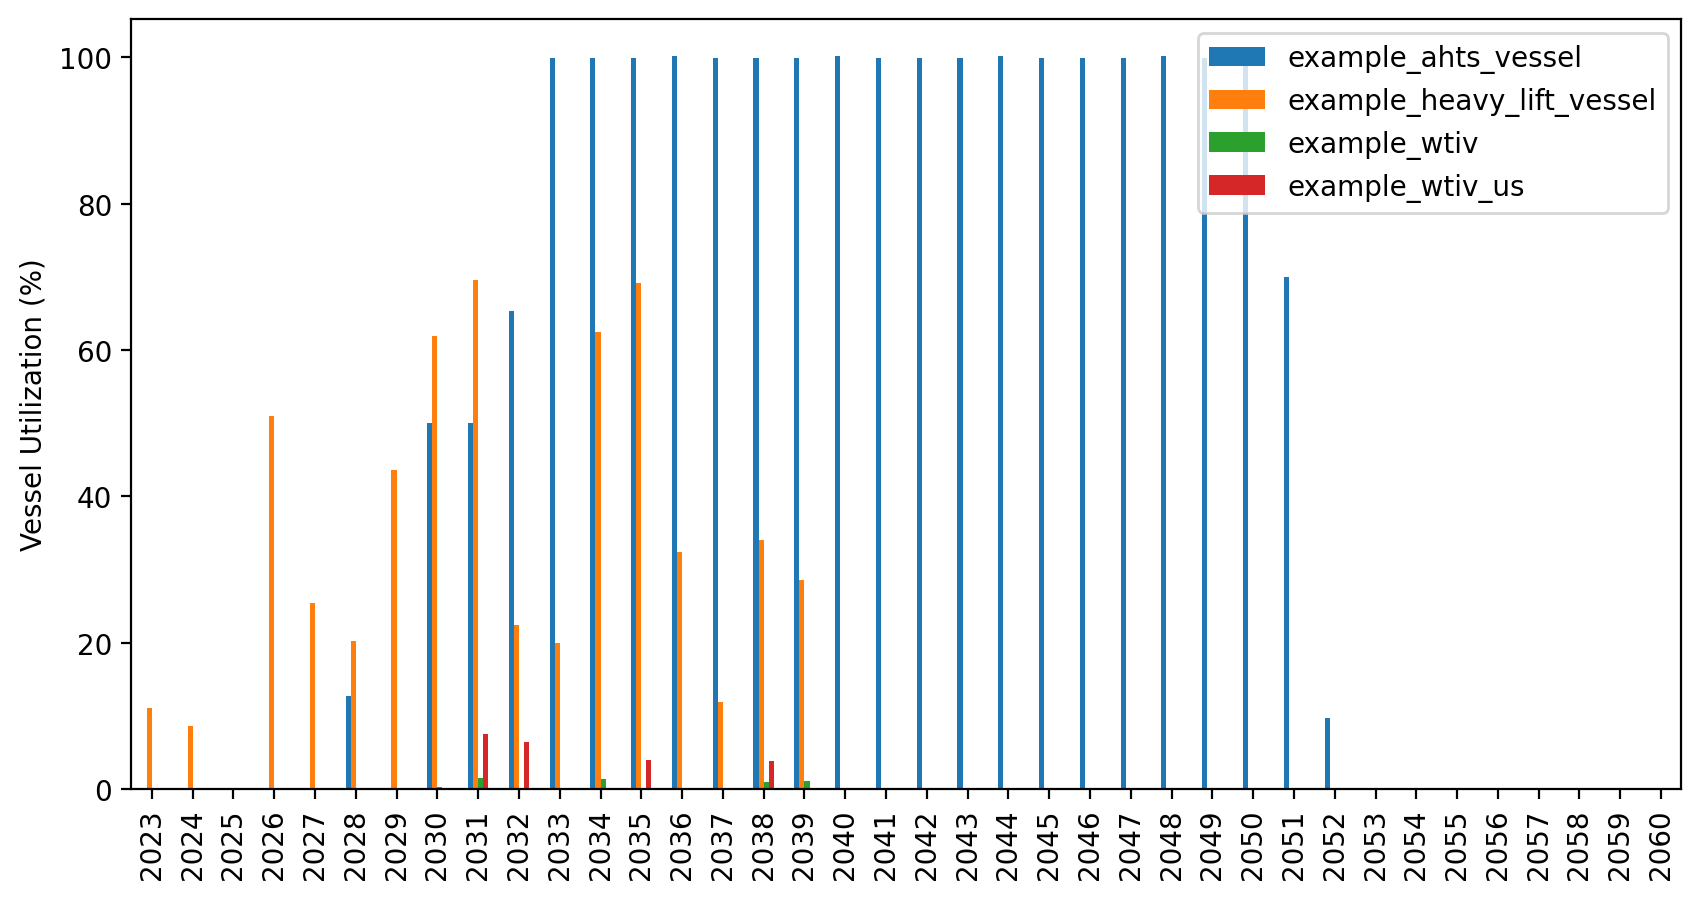

In [20]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = fig.add_subplot(111)
df_perc_util.plot(kind='bar', ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Vessel Utilization (%)")
plt.show()

In [12]:
# fig = plt.figure(figsize=(10,5), dpi=200)
# ax = fig.add_subplot(111)
# df_perc_util.plot(kind='bar', ax=ax)
# ax.set_xlabel("")
# ax.set_ylabel("Vessel Utilization (%)")
# plt.show()

def read_yaml(scenario, path):
        # set up yaml reading
    def tuple_constructor(loader, node):
        # Load the sequence of values from the YAML node
        values = loader.construct_sequence(node)
        # Return a tuple constructed from the sequence
        return tuple(values)
    # Register the constructor with PyYAML
    yaml.SafeLoader.add_constructor('tag:yaml.org,2002:python/tuple', tuple_constructor)
 
    yaml_path = '%s/%s.yaml' % (path, scenario)
    with open(yaml_path) as f:
        scenario = yaml.load(f.read(), Loader=yaml.SafeLoader)
    return(scenario)

In [13]:
vessel_types = ['example_wtiv','example_heavy_lift_vessel', 'example_wtiv_us', 'example_ahts_vessel']
vessel_rates = []
for vessel in vessel_types:
    rate_path = 'analysis/library/vessels'
    vessel_yaml = read_yaml(vessel, rate_path)
    vessel_rate = vessel_yaml['vessel_specs']['day_rate'] / 24
    vessel_rates.append(vessel_rate)
print(vessel_rates)

[12500.0, 20833.333333333332, 20833.333333333332, 4166.666666666667]


# Plot Installed Capacity

In [14]:
def installed_cap(dfs, desc):

    cum_desc = []
    i = 0
    for d in desc:
        cum_desc.append("%s cumulative" % d)
        i += 1
    yrs = np.arange(2023,2043,1)
    df_cap = pd.DataFrame(columns=desc, data = np.zeros((len(yrs), len(desc))), index = yrs)
    df_cum = pd.DataFrame(columns=cum_desc, data = np.zeros((len(yrs), len(desc))), index = yrs)

    dfs[0]['cod'] = dfs[0]['estimated_cod'].dt.year
    df_cod = dfs[0].groupby(['cod']).capacity.sum().reset_index()
    df_cod['sum'] = df_cod['capacity'].cumsum(axis=0) / 1000

    fig = plt.figure(figsize=(8, 10), dpi=200)
    ax = fig.add_subplot(1,1,1)

    # df_cod.plot(kind='line', x='cod', y='sum', color='k', ax=ax, label='Unconstrained Resources')
    i=0
    width = 0.25

    for df in dfs:
        df['finished'] = df['Date Finished'].dt.year
        df_finished = df.groupby(['finished']).capacity.sum().reset_index()
        df_finished['capacity'] = df_finished['capacity'] / 1000
        df_finished['sum'] = df_finished['capacity'].cumsum(axis=0)

        cap_mapping = dict(df_finished[['finished', 'capacity']].values)
        df_cap[desc[i]] = df_cap.index.map(cap_mapping).fillna(0)

        df_cum[cum_desc[i]] = df_cap[desc[i]].cumsum(axis=0)
        i += 1

    df = pd.concat([df_cap, df_cum], axis=1)
    # df['year'] = yrs
    # display(df)
    df[cum_desc].plot(linestyle = '-', ax=ax, use_index=False)
    df[desc].plot(kind='bar', ax=ax)
    # df_cap.plot.bar(rot=0)
    
    ax.set_xlabel("")
    ax.set_ylabel("Capacity (GW)")
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.legend()

In [15]:
installed_cap(dfs, scenarios)

In [16]:
# sample
df = pd.DataFrame({
    'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], 
    '2013_val': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 6], 
    '2014_val': [4.0, 5.0, *[float('nan')]*10], 
    '2014_target_val': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]})

# month data to datetime
df['month'] = pd.to_datetime(df['month'], format='%b')

fig, ax = plt.subplots(1, facecolor='white')
df.plot(y='2014_target_val', linestyle='-', marker='o', ax=ax)
df.plot(x='month', y=['2013_val', '2014_val'], kind='bar', ax=ax)


<AxesSubplot:xlabel='month'>

# Investment Plots

In [23]:
low_vessel_costs = {
    "example_wtiv": 550,
    "example_heavy_lift_vessel": 500,
    "example_heavy_feeder": 250,
    "example_ahts_vessel": 75
}

avg_vessel_costs = {
    "example_wtiv": 615,
    "example_heavy_lift_vessel": 625,
    "example_heavy_feeder_1kit": 250,
    "example_feeder": 250,
    "example_ahts_vessel": 80
}

high_vessel_costs = {
    "wtiv": 680,
    "hlv": 750,
    "feeder": 300,
    "ahts_vessel": 85
}

In [24]:
alloc = all_alloc[0]
print(alloc)
# display(alloc)
vessel_types = ['example_wtiv','example_heavy_lift_vessel','example_feeder', 'example_heavy_feeder_1kit','example_ahts_vessel']
init_alloc = [alloc['wtiv'][1][1], alloc['wtiv'][0][1], alloc['feeder'][1][1], alloc['feeder'][0][1], alloc['ahts_vessel'][1]]

yrs = np.arange(2023,2043)
# dates = pd.to_datetime(yrs, format='%Y')
vessel_investment = pd.DataFrame(columns=vessel_types, data = np.zeros((len(yrs), len(vessel_types))), index = dates)
vessel_investment.iloc[0] = init_alloc
display(vessel_investment)

{'ahts_vessel': ('example_ahts_vessel', 2), 'feeder': [('example_heavy_feeder_1kit', 6), ('example_feeder', 4)], 'towing_vessel': ('example_towing_vessel', 100), 'wtiv': [('example_heavy_lift_vessel', 3), ('example_wtiv', 2), ('example_wtiv_us', 1)], 'port': [('new_london', 1), ('new_bedford', 1), ('sbmt', 0), ('njwp_1', 0), ('njwp_2', 0), ('searsport_1', 0), ('searsport_2', 0), ('tradepoint_1', 0), ('tradepoint_2', 0), ('portsmouth_1', 0), ('portsmouth_2', 0), ('salem', 0), ('arthur_kill', 0)]}


NameError: name 'dates' is not defined

In [25]:
display(all_future)

[[['wtiv',
   'example_wtiv_us',
   [datetime.date(2030, 1, 1),
    datetime.date(2033, 1, 1),
    datetime.date(2036, 1, 1)]],
  ['wtiv',
   'example_heavy_lift_vessel',
   [datetime.date(2030, 1, 1),
    datetime.date(2033, 1, 1),
    datetime.date(2036, 1, 1)]],
  ['port', 'arthur_kill', [datetime.date(2027, 1, 1)]],
  ['port', 'sbmt', [datetime.date(2027, 1, 1)]],
  ['port', 'njwp_1', [datetime.date(2025, 1, 1)]],
  ['port', 'njwp_2', [datetime.date(2029, 1, 1)]],
  ['port', 'tradepoint_1', [datetime.date(2025, 1, 1)]],
  ['port', 'tradepoint_2', [datetime.date(2030, 1, 1)]],
  ['port', 'portsmouth_1', [datetime.date(2024, 1, 1)]],
  ['port', 'portsmouth_2', [datetime.date(2024, 1, 1)]],
  ['port', 'salem', [datetime.date(2026, 1, 1)]],
  ['port', 'searsport_1', [datetime.date(2030, 1, 1)]],
  ['port', 'searsport_2', [datetime.date(2035, 1, 1)]]]]

In [26]:
for vessel in vessel_types:
    for vessel_type in all_future[0]:
        if vessel_type[1] == vessel:
            years = vessel_type[2]
            print(years)
            print(len(years))
            vessel_investment.loc[years,vessel] += len(years)
    # vessel_investment[vessel] = vessel_investment[vessel] * avg_vessel_costs[vessel]

[datetime.date(2030, 1, 1), datetime.date(2033, 1, 1), datetime.date(2036, 1, 1)]
3


NameError: name 'vessel_investment' is not defined

In [27]:
display(vessel_investment)

NameError: name 'vessel_investment' is not defined

In [28]:
us_vessels = ['example_feeder', 'example_heavy_feeder_1kit', 'example_ahts_vessel']
foreign_vessels = ['example_wtiv', 'example_heavy_lift_vessel']
vessel_investment.loc[:,'us_total'] = vessel_investment[us_vessels].sum(axis=1)
vessel_investment['us_total'] = vessel_investment['us_total'].cumsum()
vessel_investment.loc[:,'foreign_total'] = vessel_investment[foreign_vessels].sum(axis=1)
vessel_investment['foreign_total'] = vessel_investment['foreign_total'].cumsum()
display(vessel_investment)

NameError: name 'vessel_investment' is not defined

In [29]:
vessel_investment['total'].plot()

NameError: name 'vessel_investment' is not defined

## Invesment from func

In [30]:
vessel_types = ['example_wtiv','example_heavy_lift_vessel', 'example_feeder', 'example_heavy_feeder_1kit', 'example_ahts_vessel']
vessel_costs = {
    "example_wtiv": 615,
    "example_heavy_lift_vessel": 625,
    "example_heavy_feeder_1kit": 250,
    "example_feeder": 100,
    "example_ahts_vessel": 80
}
# display(all_future)
display(all_alloc)

[{'ahts_vessel': ('example_ahts_vessel', 2),
  'feeder': [('example_heavy_feeder_1kit', 6), ('example_feeder', 4)],
  'towing_vessel': ('example_towing_vessel', 100),
  'wtiv': [('example_heavy_lift_vessel', 3),
   ('example_wtiv', 2),
   ('example_wtiv_us', 1)],
  'port': [('new_london', 1),
   ('new_bedford', 1),
   ('sbmt', 0),
   ('njwp_1', 0),
   ('njwp_2', 0),
   ('searsport_1', 0),
   ('searsport_2', 0),
   ('tradepoint_1', 0),
   ('tradepoint_2', 0),
   ('portsmouth_1', 0),
   ('portsmouth_2', 0),
   ('salem', 0),
   ('arthur_kill', 0)]}]

In [31]:
def investment_plot(allocs, futures, names, vessel_types, vessel_costs):
    yrs = np.arange(2023,2043)
    dates = pd.to_datetime(yrs, format='%Y')
    fig = plt.figure(figsize=(10,4), dpi=200)
    ax = fig.add_subplot(111)
    investments = pd.DataFrame(index=dates, columns=names, data=np.zeros((len(yrs), len(names))))
    for i in range(0,len(names)):
        init_alloc = [allocs[i]['wtiv'][1][1], allocs[i]['wtiv'][0][1], allocs[i]['ahts_vessel'][1]]
        vessel_investment = pd.DataFrame(columns=vessel_types, data = np.zeros((len(yrs), len(vessel_types))), index = dates)
        vessel_investment.iloc[0] = init_alloc

        for vessel in vessel_types:
            for vessel_type in futures[i]:
                if vessel_type[1] == vessel:
                    years = vessel_type[2]
                    vessel_investment.loc[years,vessel] += 1
            vessel_investment[vessel] = vessel_investment[vessel] * vessel_costs[vessel]
        
        vessel_investment.loc[:,'total'] = vessel_investment.sum(axis=1)
        vessel_investment['total'] = vessel_investment['total'].cumsum()

        vessel_investment['total'].plot(label=names[i])
        investments[names[i]] = vessel_investment['total']
    investments['year'] = yrs
    investments.set_index('year', inplace=True)
    display(investments)
    ax.legend()
        

In [34]:
plt.close()
def vessel_investment_plot(allocs, futures, names, vessel_types, vessel_costs):
    yrs = np.arange(2023,2043)
    dates = pd.to_datetime(yrs, format='%Y')
    fig, axes = plt.subplots(2,1, figsize=(10,6), dpi=200, sharex=True)

    us_investments = pd.DataFrame(index=dates, columns=names, data=np.zeros((len(yrs), len(names))))
    total_investments = pd.DataFrame(index=dates, columns=names, data=np.zeros((len(yrs), len(names))))
    foreign_investments = pd.DataFrame(index=dates, columns=names, data=np.zeros((len(yrs), len(names))))
    for i in range(0,len(names)):
        init_alloc = [allocs[i]['wtiv'][1][1], allocs[i]['wtiv'][0][1], allocs[i]['feeder'][1][1], allocs[i]['feeder'][0][1], allocs[i]['ahts_vessel'][1]]
        vessel_investment = pd.DataFrame(columns=vessel_types, data = np.zeros((len(yrs), len(vessel_types))), index = dates)
        vessel_investment.iloc[0] = init_alloc
        # display(vessel_investment)
        for vessel in vessel_types:
            for vessel_type in futures[i]:
                if vessel_type[1] == vessel:
                    years = vessel_type[2]
                    # print(vessel_type[1])
                    # print(years)
                    for year in years:
                        vessel_investment.loc[[year],vessel] += 1
            # vessel_investment[vessel] = vessel_investment[vessel] * vessel_costs[vessel]
        
        us_vessels = ['example_feeder', 'example_heavy_feeder_1kit', 'example_ahts_vessel']
        foreign_vessels = ['example_wtiv', 'example_heavy_lift_vessel']
        vessel_investment.loc[:,'us_total'] = vessel_investment[us_vessels].sum(axis=1)
        vessel_investment['us_total'] = vessel_investment['us_total'].cumsum() # / 1000
        vessel_investment.loc[:,'foreign_total'] = vessel_investment[foreign_vessels].sum(axis=1)
        vessel_investment['foreign_total'] = vessel_investment['foreign_total'].cumsum() # /1000
        vessel_investment.loc[:,'total'] = vessel_investment[vessel_types].sum(axis=1)
        vessel_investment['total'] = vessel_investment['total'].cumsum() # / 1000

        total_investments[names[i]] = vessel_investment['total']
        us_investments[names[i]] = vessel_investment['us_total']
        foreign_investments[names[i]] = vessel_investment['foreign_total']
    us_investments['year'] = yrs
    us_investments.set_index('year', inplace=True)

    total_investments['year'] = yrs
    total_investments.set_index('year', inplace=True)

    us_investments['year'] = yrs
    us_investments.set_index('year', inplace=True)
    us_investments.plot(ax=axes[0])
    # display(vessel_investment)

    foreign_investments['year'] = yrs
    foreign_investments.set_index('year', inplace=True)
    foreign_investments.plot(ax=axes[1])

    axes[0].set_ylabel('US ($B)')
    axes[1].set_ylabel('Foreign ($B)')
    axes[0].yaxis.set_major_locator(tck.MaxNLocator(integer=True))
    plt.minorticks_off()
    # plt.tick_params(bottom = False) 
    axes[0].set_xticks(yrs[::2])
    fig.suptitle('Vessel Investments')
    plt.show()

    # return us_investments, foreign_investments

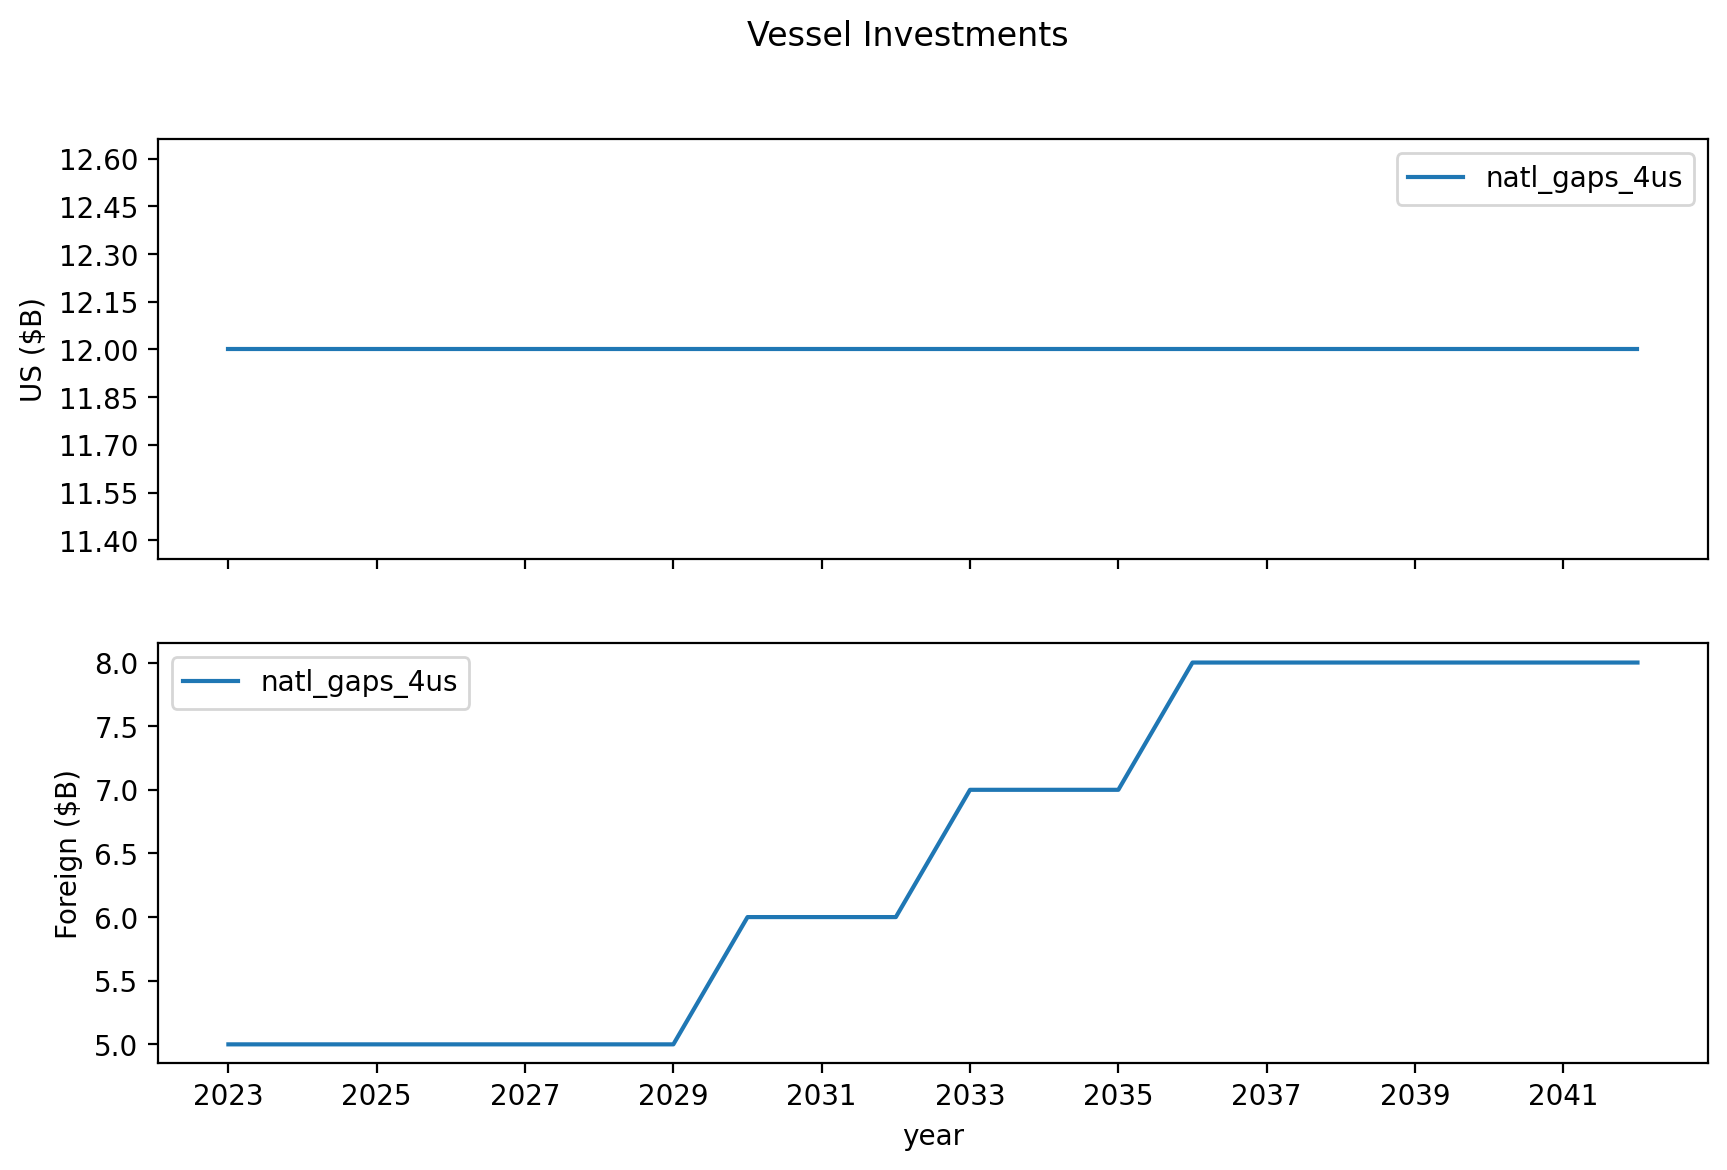

In [36]:
vessel_investment_plot(all_alloc, all_future, scenarios, vessel_types, vessel_costs)

# Installed Capacity CSV

In [ ]:
yrs = np.arange(2023,2043,1)
installed_cap = pd.DataFrame(columns=scenarios, data = np.zeros((len(yrs), len(scenarios))), index = yrs)
display(installed_cap)


: 

In [ ]:
for df in dfs:
        df['finished'] = df['Date Finished'].dt.year
        df_finished = df.groupby(['finished']).capacity.sum().reset_index()
        display(df_finished)

        mapping = dict(df_finished[['finished','capacity']].values)
        installed_cap['best_path_forward'] = installed_cap.index.map(mapping)
        display(installed_cap)

: 

: 

# Throughput Plot

In [ ]:
df = dfs[0]

: 

In [ ]:
res = []

for _, project in df.iterrows():

    if project["Date Finished"].year == project["Date Started"].year:
        res.append((project["Date Finished"].year, project["port"], project["capacity"]))

    else:

        total = project["Date Finished"].date() - project["Date Started"].date()
        for year in np.arange(project["Date Started"].year, project["Date Finished"].year + 1):
            if year == project["Date Started"].year:
                perc = (dt.date(year + 1, 1, 1) - project["Date Started"].date()) / total

            elif year == project["Date Finished"].year:
                perc = (project["Date Finished"].date() - dt.date(year, 1, 1)) / total

            else:
                perc = (dt.date(year + 1, 1, 1) - dt.date(year, 1, 1)) / total

            res.append((year, project["port"], perc * project["capacity"]))

throughput = pd.DataFrame(res, columns=["year", "port", "capacity"]).pivot_table(
    index=["year"],
    columns=["port"],
    aggfunc="sum",
    fill_value=0.
)["capacity"]

display(throughput)

fig = plt.figure(figsize=(6, 4), dpi=200)
ax = fig.add_subplot(111)

throughput.plot.bar(ax=ax, width=0.75)

ax.set_ylim(0, 2000)

ax.set_ylabel("Annual Capacity Throughput (MW)")
ax.set_xlabel("")

plt.xticks(rotation=0, fontsize=6)
plt.yticks(fontsize=6)

ax.legend(fontsize=6, ncol=5)
# fname_t = 'east_coast_analysis/figures/sc_roadmap_gaps/throughput_'+fig_name+'.png'
# fig.savefig(fname_t, dpi=300)

: 

In [ ]:
plt.subplot(221)

# equivalent but more general
ax1 = plt.subplot(2, 2, 1)

# add a subplot with no frame
ax2 = plt.subplot(222, frameon=False)

# add a polar subplot
plt.subplot(223, projection='polar')

# add a red subplot that shares the x-axis with ax1
plt.subplot(224, sharex=ax1, facecolor='red')

# delete ax2 from the figure
# plt.delaxes(ax2)

# # add ax2 to the figure again
# plt.subplot(ax2)

# make the first Axes "current" again
plt.subplot(221)

: 

# Investment Plot

In [ ]:
fig = plt.figure(figsize=(6, 4), dpi=200)
ax = fig.add_subplot(111)
# ax.axhline(y=700, color='k', linestyle='-', linewidth=0.8)
# ax.axhline(y=1000, color='k', linestyle='-', linewidth=0.8)
y1 = ax.step(np.arange(2023,2050), [1000] * len(np.arange(2023,2050)), where='mid', linestyle='-', color='blue')
print(len(y1))
plt.show()

# ax.fill_between(np.arange(2023,2050), 1000, 700, where=(1000>=700), interpolate=True, alpha=0.8, color='#E6E6FA')

: 

: 